<a href="https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/image_2_image_using_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image2Image Pipeline for Stable Diffusion using 🧨 Diffusers 

This notebook shows how to create a custom `diffusers` pipeline for  text-guided image-to-image generation with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).



In [1]:
!nvidia-smi

Sat May 31 22:02:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.70                 Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090      WDDM  |   00000000:02:00.0  On |                  N/A |
| 33%   30C    P0             41W /  575W |    5897MiB /  32607MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install diffusers transformers ftfy accelerate


To use private and gated models on 🤗 Hugging Face Hub, login is required. If you are only using a public checkpoint (such as `CompVis/stable-diffusion-v1-4` in this notebook), you can skip this step.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Image2Image pipeline.

In [4]:
import inspect
import warnings
from typing import List, Optional, Union

import torch
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

Load the pipeline

In [5]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Download an initial image and preprocess it so we can pass it to the pipeline.

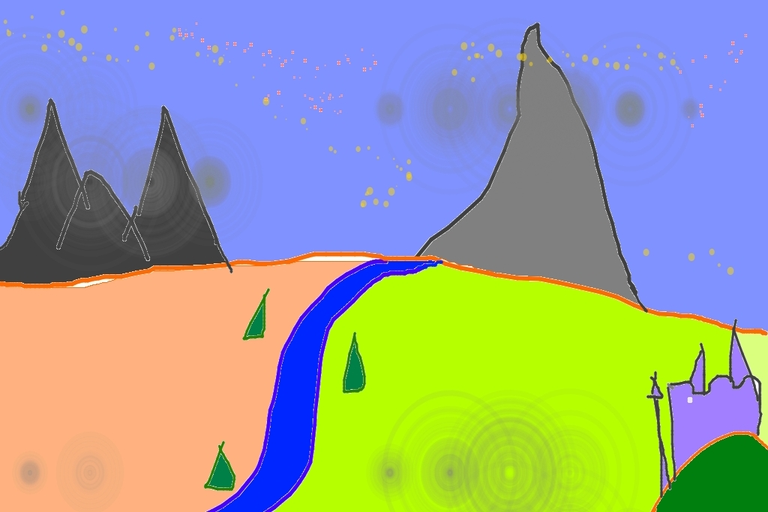

In [6]:
import requests
from io import BytesIO
from PIL import Image

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((768, 512))
init_img

Define the prompt and run the pipeline.

In [7]:
prompt = "A fantasy landscape, trending on artstation"

Here, `strength` is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 allow for lots of variations but will also produce images that are not semantically consistent with the input.

In [8]:
generator = torch.Generator(device=device).manual_seed(1024)
image = pipe(prompt=prompt, image=init_img, strength=0.75, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/37 [00:00<?, ?it/s]

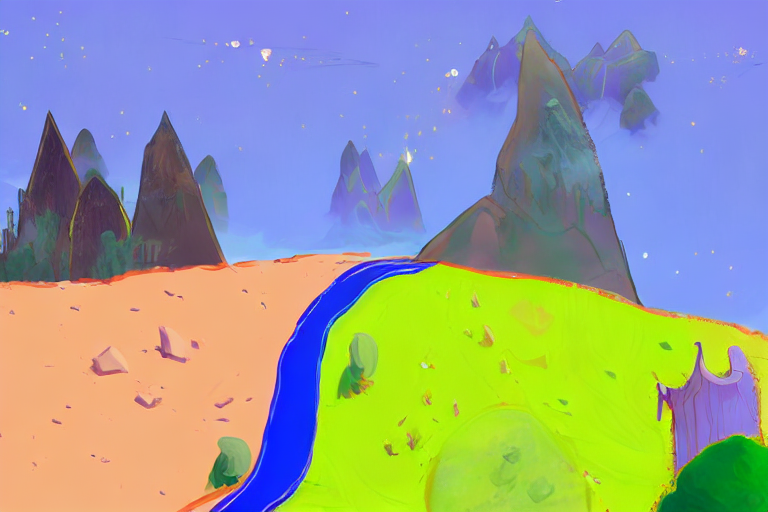

In [38]:
image

As you can see, when using a lower value for `strength`, the generated image is more closer to the original `image`


Now using [LMSDiscreteScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/lms_discrete)

In [12]:
from diffusers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = lms

In [13]:
generator = torch.Generator(device=device).manual_seed(1024)
image = pipe(prompt=prompt, image=init_img, strength=0.75, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/37 [00:00<?, ?it/s]

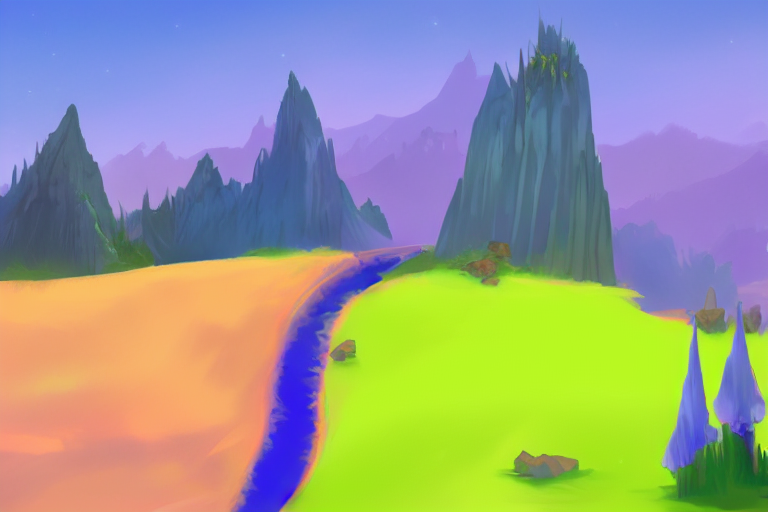

In [14]:
image